In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import os
import sys
import nltk
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [4]:
df = pd.read_csv('data.csv')
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [5]:
df.shape

(8518, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [7]:
# check for missing values
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [8]:
# Remove rows with missing values in critical columns
df_cleaned = df.dropna(
    subset=['Reviewer Name', 'Review Title', 'Review text', 'Ratings']
).copy()   # ✅ make an explicit copy

# Fill missing values safely (without inplace)
df_cleaned['Place of Review'] = df_cleaned['Place of Review'].fillna('Unknown')
df_cleaned['Month'] = df_cleaned['Month'].fillna('Unknown')

# Check the result
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_cleaned.shape}")
print(f"\nMissing values after cleaning:\n{df_cleaned.isnull().sum()}")


Original shape: (8518, 8)
Cleaned shape: (8508, 8)

Missing values after cleaning:
Reviewer Name      0
Review Title       0
Place of Review    0
Up Votes           0
Down Votes         0
Month              0
Review text        0
Ratings            0
dtype: int64


In [9]:
df['Ratings'].value_counts()

Ratings
5    5080
4    1746
1     769
3     615
2     308
Name: count, dtype: int64

In [10]:
# Keep only valid ratings
df = df[df["Ratings"].isin([1,2,3,4,5])]

# Remove neutral reviews (3 stars)
df = df[df["Ratings"] != 3]

# Create sentiment label
df["Sentiment"] = df["Ratings"].apply(lambda x: 1 if x >= 4 else 0)

df["Sentiment"].value_counts()


Sentiment
1    6826
0    1077
Name: count, dtype: int64

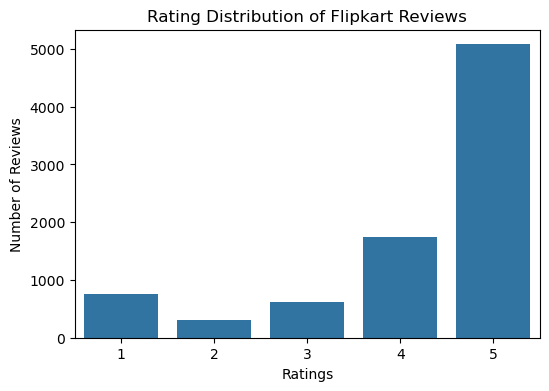

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x='Ratings', data=df_cleaned)
plt.title("Rating Distribution of Flipkart Reviews")
plt.xlabel("Ratings")
plt.ylabel("Number of Reviews")
plt.show()


#### The rating distribution shows a strong skew towards higher ratings, suggesting that most customers are satisfied with the product.

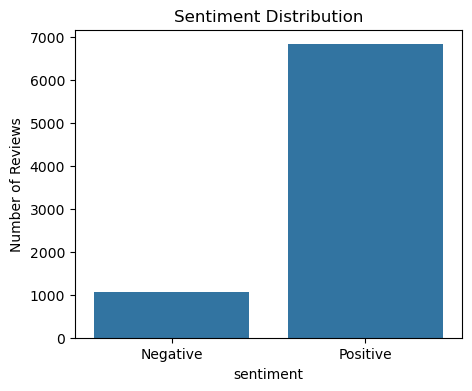

sentiment
1    6822
0    1071
Name: count, dtype: int64

In [12]:
# Positive vs Negative Reviews
df_eda = df_cleaned[df_cleaned['Ratings'] != 3].copy()
df_eda['sentiment'] = df_eda['Ratings'].apply(lambda x: 1 if x >= 4 else 0)

plt.figure(figsize=(5,4))
sns.countplot(x='sentiment', data=df_eda)
plt.xticks([0,1], ['Negative', 'Positive'])
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution")
plt.show()


df_eda['sentiment'].value_counts()


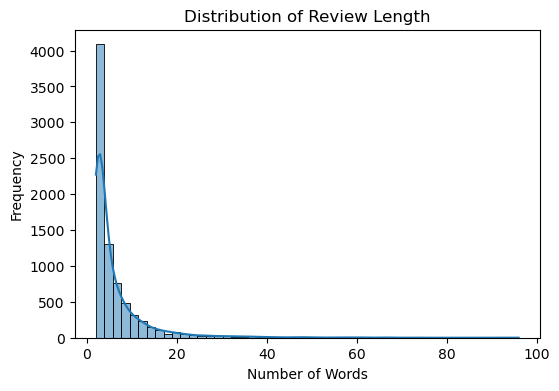

sentiment
0    10.499533
1     5.491205
Name: review_length, dtype: float64

In [13]:
# review length analysis

df_eda['review_length'] = df_eda['Review text'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(df_eda['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Length")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

df_eda.groupby('sentiment')['review_length'].mean()


#### Negative reviews tend to be longer on average, indicating that dissatisfied customers provide more detailed feedback compared to satisfied customers.

In [14]:
# Top Keywords in Negative Reviews
from sklearn.feature_extraction.text import CountVectorizer

neg_reviews = df[df["Sentiment"] == 0]["Review text"].astype(str)

cv = CountVectorizer(stop_words="english", max_features=20)
X = cv.fit_transform(neg_reviews)

keywords = cv.get_feature_names_out()
print(keywords)


['bad' 'box' 'buy' 'don' 'flipkart' 'good' 'goodread' 'got' 'mavis'
 'original' 'poor' 'product' 'productread' 'quality' 'qualityread' 'read'
 'shuttle' 'shuttles' 'time' 'worst']


In [15]:
# Top keyords in Positive Reviews
pos_reviews = df[df["Sentiment"] == 1]["Review text"].astype(str)
cv_bigram = CountVectorizer(stop_words="english", ngram_range=(2,2), max_features=20)
X2 = cv_bigram.fit_transform(pos_reviews)

bigrams = cv_bigram.get_feature_names_out()
print("Top bigrams in positive reviews:")
print(bigrams)


Top bigrams in positive reviews:
['best shuttle' 'fast delivery' 'genuine product' 'good oneread'
 'good product' 'good productread' 'good quality' 'good qualityread'
 'good read' 'good shuttle' 'mavis 350' 'nice product' 'nice productread'
 'nice read' 'original product' 'product good' 'product read'
 'quality good' 'quality read' 'shuttle read']


In [16]:
# Customer Pain Points (Most Frequent Words in Negative and Positive Reviews)
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def top_words(texts, n=20):
    words = []
    for text in texts:
        text = str(text).lower()
        text = re.sub(r'[^a-z ]', '', text)
        words += [w for w in text.split() if w not in stop_words]
    return Counter(words).most_common(n)

neg_words = top_words(df_eda[df_eda['sentiment'] == 0]['Review text'], 20)
pos_words = top_words(df_eda[df_eda['sentiment'] == 1]['Review text'], 20)

print("Top words in Negative Reviews:", neg_words)
print("Top words in Positive Reviews:", pos_words)


Top words in Negative Reviews: [('quality', 253), ('product', 201), ('shuttle', 184), ('bad', 178), ('qualityread', 122), ('shuttles', 116), ('good', 116), ('worst', 102), ('poor', 89), ('goodread', 88), ('productread', 79), ('dont', 71), ('one', 67), ('buy', 63), ('mavis', 52), ('badread', 52), ('read', 50), ('got', 46), ('box', 45), ('time', 44)]
Top words in Positive Reviews: [('good', 1806), ('goodread', 1185), ('productread', 951), ('product', 737), ('nice', 733), ('niceread', 456), ('quality', 404), ('best', 393), ('qualityread', 388), ('shuttle', 371), ('read', 285), ('original', 258), ('delivery', 216), ('superread', 201), ('one', 175), ('price', 172), ('genuine', 154), ('shuttles', 149), ('shuttleread', 138), ('oneread', 138)]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
import re

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def text_cleaning(text):
    text = str(text).lower()                      # lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)     # remove special chars & punctuation
    text = re.sub(r'\s+', ' ', text).strip()     # remove extra spaces

    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords

    return " ".join(words)


df['clean_text'] = df['Review text'].apply(text_cleaning)

df[['Review text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review text,clean_text
0,"Nice product, good quality, but price is now r...",nice product good quality price rising bad sig...
1,They didn't supplied Yonex Mavis 350. Outside ...,supplied yonex mavis outside cover yonex ad in...
2,Worst product. Damaged shuttlecocks packed in ...,worst product damaged shuttlecocks packed new ...
4,Over pricedJust â?¹620 ..from retailer.I didn'...,pricedjust retailer understand wat advantage b...
5,Good quality product. Delivered on time.READ MORE,good quality product delivered time read


In [18]:
# check empty cleaned reviews
empty_count = (df['clean_text'].str.len() == 0).sum()
print("Empty cleaned reviews:", empty_count)

# remove empty cleaned reviews if any
df = df[df['clean_text'].str.len() > 0].copy()
print("Final shape after removing empty cleaned text:", df.shape)


Empty cleaned reviews: 0
Final shape after removing empty cleaned text: (7903, 10)


In [19]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    words = text.split()
    words = [stemmer.stem(w) for w in words]
    return " ".join(words)

df['stemmed_text'] = df['clean_text'].apply(stem_text)

df[['clean_text', 'stemmed_text']].head()


,clean_text,stemmed_text
0,nice product good quality price rising bad sig...,nice product good qualiti price rise bad sign ...
1,supplied yonex mavis outside cover yonex ad in...,suppli yonex mavi outsid cover yonex ad insid ...
2,worst product damaged shuttlecocks packed new ...,worst product damag shuttlecock pack new box o...
4,pricedjust retailer understand wat advantage b...,pricedjust retail understand wat advantag buy ...
5,good quality product delivered time read,good qualiti product deliv time read


In [20]:
# If not created yet:
df_model = df[df['Ratings'] != 3].copy()
df_model['sentiment'] = df_model['Ratings'].apply(lambda r: 1 if r >= 4 else 0)


X_text = df_model['clean_text'].astype(str)     # OR df_model['stemmed_text']
y = df_model['sentiment']

In [21]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42,
)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=5000, stop_words="english")
X_bow = bow.fit_transform(df["clean_text"])

print(X_bow.shape)

(7903, 2910)


In [23]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow  = bow_vectorizer.transform(X_test_text)

print("BoW train shape:", X_train_bow.shape)
print("BoW test shape :", X_test_bow.shape)

BoW train shape: (6322, 2594)
BoW test shape : (1581, 2594)


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95
)

X_tfidf = tfidf.fit_transform(df["clean_text"])
print(X_tfidf.shape)


(7903, 2937)


In [25]:
# Train–Test Split
from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Build a pipeline (like your scaler+model style)
pipeline_1 = Pipeline(
    [
        ("Vectorizer", TfidfVectorizer(stop_words="english")),
        ("Model", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]
)

In [27]:
def objective(trial):
    # Choose vectorizer type
    vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf", "bow"])

    if vectorizer_type == "tfidf":
        pipeline_1.set_params(
            Vectorizer=TfidfVectorizer(
                stop_words="english",
                ngram_range=trial.suggest_categorical("ngram_range", [(1,1), (1,2)]),
                min_df=trial.suggest_int("min_df", 2, 5),
                max_df=trial.suggest_float("max_df", 0.85, 0.98),
            )
        )
    else:
        pipeline_1.set_params(
            Vectorizer=CountVectorizer(
                stop_words="english",
                ngram_range=trial.suggest_categorical("ngram_range", [(1,1), (1,2)]),
                min_df=trial.suggest_int("min_df", 2, 5),
                max_df=trial.suggest_float("max_df", 0.85, 0.98),
            )
        )

In [28]:
!pip install optuna -q

In [29]:

import optuna
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def objective(trial):
    # 1. Choose vectorizer type and parameters
    vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf", "bow"])
    ngram_range = trial.suggest_categorical("ngram_range", [(1, 1), (1, 2)])
    min_df = trial.suggest_int("min_df", 2, 5)
    max_df = trial.suggest_float("max_df", 0.85, 0.98)

    if vectorizer_type == "tfidf":
        vectorizer = TfidfVectorizer(stop_words="english", ngram_range=ngram_range, min_df=min_df, max_df=max_df)
    else:
        vectorizer = CountVectorizer(stop_words="english", ngram_range=ngram_range, min_df=min_df, max_df=max_df)

    # 2. Choose model and parameters
    model_type = trial.suggest_categorical("model_type", ["logreg", "linearsvc", "nb", "knn"])

    if model_type == "logreg":
        clf = LogisticRegression(max_iter=2000, class_weight="balanced", C=trial.suggest_float("C_log", 0.1, 10.0, log=True))
    elif model_type == "linearsvc":
        clf = LinearSVC(class_weight="balanced", C=trial.suggest_float("C_svc", 0.1, 10.0, log=True), dual=False)
    elif model_type == "nb":
        clf = MultinomialNB(alpha=trial.suggest_float("alpha", 0.1, 2.0))
    else:  # knn
        clf = KNeighborsClassifier(n_neighbors=trial.suggest_int("n_neighbors", 3, 31, 2), metric="cosine")

    # 3. Build and Evaluate Pipeline
    pipeline = Pipeline([
        ("Vectorizer", vectorizer),
        ("Model", clf)
    ])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, X_train, y_train, scoring="f1_macro", cv=skf).mean()
    return score

# Create and run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Parameters:\n", study.best_params)
print("Best CV F1 (macro):", study.best_value)

[I 2026-02-09 15:17:09,325] A new study created in memory with name: no-name-312f349b-36ae-4120-87c8-a5b8ff62fbff
d:\Anaconda\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  optuna_warn(message)
d:\Anaconda\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  optuna_warn(message)
[I 2026-02-09 15:17:09,703] Trial 0 finished with value: 0.7749623877819773 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': (1, 1), 'min_df': 5, 'max_df': 0.9214353989316704, 'model_type': 'linearsvc', 'C_svc': 0.15774232434352267}. Best is trial 0 with value: 0.7749623877819773.
d:\Anaconda\Lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a c

Best Parameters:
 {'vectorizer_type': 'bow', 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.9500403485647395, 'model_type': 'nb', 'alpha': 0.6827597979324775}
Best CV F1 (macro): 0.833314122293425


In [30]:
print("Best Parameters:\n", study.best_params)
print("Best CV F1 (macro):", study.best_value)

Best Parameters:
 {'vectorizer_type': 'bow', 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.9500403485647395, 'model_type': 'nb', 'alpha': 0.6827597979324775}
Best CV F1 (macro): 0.833314122293425


In [31]:
best_params = study.best_params

# Rebuild best pipeline cleanly (recommended)
# We'll re-apply vectorizer and model based on best_params
vectorizer_type = best_params["vectorizer_type"]
ngram_range = best_params["ngram_range"]
min_df = best_params["min_df"]
max_df = best_params["max_df"]
model_type = best_params["model_type"]

if vectorizer_type == "tfidf":
    vectorizer = TfidfVectorizer(stop_words="english", ngram_range=ngram_range, min_df=min_df, max_df=max_df)
else:
    vectorizer = CountVectorizer(stop_words="english", ngram_range=ngram_range, min_df=min_df, max_df=max_df)

if model_type == "logreg":
    model = LogisticRegression(max_iter=2000, class_weight="balanced", C=best_params["C"])
elif model_type == "linearsvc":
    model = LinearSVC(class_weight="balanced", C=best_params["C"])
elif model_type == "nb":
    model = MultinomialNB(alpha=best_params["alpha"])
else:
    model = KNeighborsClassifier(n_neighbors=best_params["n_neighbors"], metric="cosine")

final_pipeline = Pipeline(
    [
        ("Vectorizer", vectorizer),
        ("Model", model)
    ]
)

# Training
final_pipeline.fit(X_train, y_train)

# Testing
y_pred_test = final_pipeline.predict(X_test)

print("Test F1 (macro):", f1_score(y_test, y_pred_test, average="macro"))
print("\nReport:\n", classification_report(y_test, y_pred_test, digits=4))


Test F1 (macro): 0.8441433528393565

Report:
               precision    recall  f1-score   support

           0     0.7760    0.6866    0.7286       217
           1     0.9510    0.9685    0.9597      1364

    accuracy                         0.9298      1581
   macro avg     0.8635    0.8276    0.8441      1581
weighted avg     0.9270    0.9298    0.9280      1581



In [32]:
import joblib

# Save the final pipeline
joblib.dump(final_pipeline, 'sentiment_model.pkl')
#joblib.dump(study.best_params, 'best_params.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')



print("Model saved as sentiment_model.pkl")

Model saved as sentiment_model.pkl


In [33]:
import pandas as pd

# Create the predictions DataFrame using the test set results
predictions = pd.DataFrame({
    'processed_text': X_test,
    'prediction_label': y_pred_test
})

# Filter rows where Predicted is 'Positive' (label 1)
df_positive = predictions[predictions['prediction_label'] == 1]

# Select only Processed Text and prediction label
case1_info = df_positive[['processed_text', 'prediction_label']]

case1_info.head()

,processed_text,prediction_label
506,product goodread,1
1830,good qualityread,1
3575,nice shettles maintained quality till matches ...,1
7893,goodread,1
6270,little bit lasting expected read,1


In [34]:
# Filter rows where Predicted is 'Negative'
df_negative = predictions[predictions['prediction_label'] == 0]

# Select only Processed Text column
case2_info = df_negative[['processed_text',	'prediction_label']]

case2_info.head()

,processed_text,prediction_label
2224,inside shuttle local brand abysmal quality read,0
6973,received packing looseread,0
6804,plastic cover torn slightly product goodread,0
6617,delivery bad product goodread,0
2178,worst experience purchaseread,0


In [35]:
import joblib

# Load the saved model pipeline
loaded_model = joblib.load('sentiment_model.pkl')

def predict_new_review(text):
    # The pipeline handles both vectorization and prediction
    prediction = loaded_model.predict([text])[0]
    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment

# Example usage
test_review = "2224	inside shuttle local brand abysmal quality read	0"
print(f"Review: {test_review}")
print(f"Predicted Sentiment: {predict_new_review(test_review)}")

Review: 2224	inside shuttle local brand abysmal quality read	0
Predicted Sentiment: Negative
